In [1]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import os
import seaborn as sns
import plotly.express as px
from plotly.subplots import make_subplots
import tensorflow.keras as keras
from tqdm import tqdm
from tensorflow.keras.optimizers import Adam, Adamax


sns.set_style('whitegrid')
template = 'seaborn'

2024-05-04 13:27:12.850422: I tensorflow/core/util/port.cc:111] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-05-04 13:27:13.094660: E tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:9342] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-05-04 13:27:13.094693: E tensorflow/compiler/xla/stream_executor/cuda/cuda_fft.cc:609] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-05-04 13:27:13.096059: E tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:1518] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-05-04 13:27:13.208291: I tensorflow/core/platform/cpu_feature_g

In [2]:
BASE_PATH = './'

In [3]:
size = (168, 168)

In [4]:
train = pd.read_csv(f'{BASE_PATH}/training_data.csv', sep=";")
test = pd.read_csv(f'{BASE_PATH}/testing_data.csv', sep=";")

In [5]:
num_classes = len(train['class'].unique())
num_classes

4

In [6]:
from typing import Tuple


def preprocessing_image(path: str, shape: Tuple[int, int], normalize: bool = False) -> np.ndarray:
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    if shape:
        image = cv2.resize(image, shape)
    if normalize:
        image = image/255
    return image

In [7]:
images = [preprocessing_image(f"{BASE_PATH}/{image}", size, normalize=True) for image in train['path']]
labels = [label for label in train['class']]

In [8]:
images = np.array(images)
labels = np.array(labels)

In [9]:
from sklearn.model_selection import train_test_split


X_train, X_val, y_train, y_val = train_test_split(images, labels, test_size=0.2, shuffle=True)

In [10]:
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomContrast(0.1),
    keras.layers.RandomBrightness(0.1),
])

2024-05-04 13:27:25.019619: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-04 13:27:25.224733: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-04 13:27:25.224786: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-04 13:27:25.226536: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:880] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-05-04 13:27:25.226575: I tensorflow/compile

In [11]:
model = keras.Sequential([
    # data_augmentation,

    keras.layers.Conv2D(filters=16, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=32, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=64, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.BatchNormalization(),

    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.Conv2D(filters=128, kernel_size=(3,3), activation='relu'),
    keras.layers.MaxPool2D(),
    keras.layers.BatchNormalization(),
    
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dropout(0.4),


    keras.layers.Flatten(),    
    keras.layers.Dense(num_classes, activation='softmax')
])

In [12]:
model.compile(
    optimizer=Adam(learning_rate=0.0001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

In [40]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 166, 166, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2  (None, 83, 83, 16)        0         
 D)                                                              
                                                                 
 batch_normalization (Batch  (None, 83, 83, 16)        64        
 Normalization)                                                  
                                                                 
 conv2d_1 (Conv2D)           (None, 81, 81, 32)        4640      
                                                                 
 conv2d_2 (Conv2D)           (None, 79, 79, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 39, 39, 32)       

In [14]:
history = model.fit(
                    x=X_train,
                    y=y_train,
                    validation_data=(X_val, y_val),
                    epochs=20,
                    batch_size=16
                  )

Epoch 1/20


2024-05-04 13:27:28.608453: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential_1/dropout/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
2024-05-04 13:27:28.745100: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:442] Loaded cuDNN version 8907
2024-05-04 13:27:28.878842: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-04 13:27:29.235299: I tensorflow/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2024-05-04 13:27:29.596684: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7f5a4cb15cd0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-05-04 13:27:29.596709: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 4070, Compute

250/250 [==============================] - 7s 14ms/step - loss: 0.7185 - accuracy: 0.7136 - val_loss: 1.2489 - val_accuracy: 0.3197
Epoch 2/20
250/250 [==============================] - 2s 10ms/step - loss: 0.3997 - accuracy: 0.8564 - val_loss: 0.5957 - val_accuracy: 0.7777
Epoch 3/20
250/250 [==============================] - 2s 10ms/step - loss: 0.2648 - accuracy: 0.9090 - val_loss: 0.5036 - val_accuracy: 0.8215
Epoch 4/20
250/250 [==============================] - 2s 10ms/step - loss: 0.1937 - accuracy: 0.9312 - val_loss: 0.2969 - val_accuracy: 0.8926
Epoch 5/20
250/250 [==============================] - 2s 10ms/step - loss: 0.1498 - accuracy: 0.9502 - val_loss: 0.3044 - val_accuracy: 0.8950
Epoch 6/20
250/250 [==============================] - 2s 10ms/step - loss: 0.1061 - accuracy: 0.9690 - val_loss: 0.3494 - val_accuracy: 0.8891
Epoch 7/20
250/250 [==============================] - 2s 10ms/step - loss: 0.0762 - accuracy: 0.9805 - val_loss: 0.2677 - val_accuracy: 0.9096
Epoch 8/20

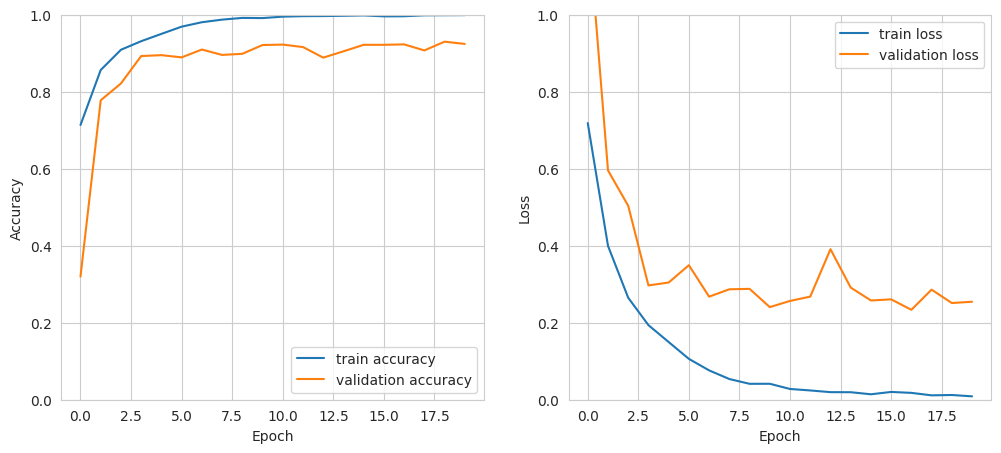

In [15]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

ax1.plot(history.history['accuracy'], label='train accuracy')
ax1.plot(history.history['val_accuracy'], label='validation accuracy')
ax1.grid(True)
ax1.legend(loc='lower right')
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_ylim([0, 1])

ax2.plot(history.history['loss'], label='train loss')
ax2.plot(history.history['val_loss'], label='validation loss')
ax2.grid(True)
ax2.legend(loc='upper right')
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_ylim([0, 1])

plt.show()

In [31]:
test = pd.read_csv(f'{BASE_PATH}/testing_data.csv', sep=";")
test_images = [preprocessing_image(f"{BASE_PATH}/{image}", size, normalize=True) for image in test['path']]
test_labels = [label for label in test['class']]
class_names = train['class_name'].unique()

In [32]:
test_loss, test_accuracy = model.evaluate(np.array(test_images), np.array(test_labels))
print(f"Test accuracy: {test_accuracy}")

41/41 [==============================] - 0s 6ms/step - loss: 0.2450 - accuracy: 0.9329
Test accuracy: 0.9328756928443909


In [34]:
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report


y_pred = model.predict(np.array(test_images))
y_pred = np.argmax(y_pred, axis=1)

y_true = test_labels

conf_matrix = confusion_matrix(y_true, y_pred)

class_report = classification_report(y_true, y_pred, target_names=class_names)

print(class_report)


41/41 [==============================] - 0s 5ms/step
              precision    recall  f1-score   support

   pituitary       0.96      0.86      0.90       300
      glioma       0.85      0.89      0.87       306
  meningioma       0.95      0.99      0.97       405
     notumor       0.97      0.98      0.97       300

    accuracy                           0.93      1311
   macro avg       0.93      0.93      0.93      1311
weighted avg       0.93      0.93      0.93      1311



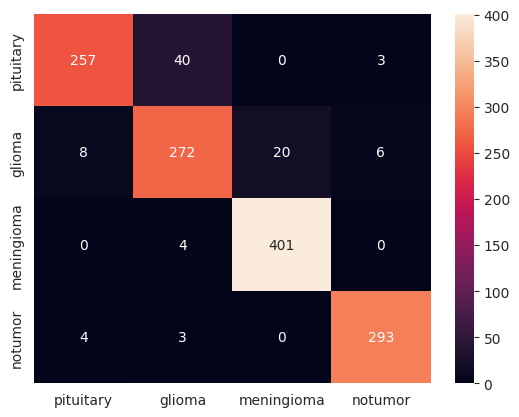

In [39]:
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
plt.show()